In [1]:
import numpy as np
from astropy.io import ascii
import pandas as pd
import matplotlib.pyplot as plt
import pystan as ps
import arviz as av
import seaborn as sns
import pickle

%matplotlib inline

In [15]:
data = ascii.read('/Users/samberek/Courses/1501project/data/table5/NGC1407_GC.cat')

In [16]:
data

ID,RA,DEC,RV,RV_err,RAD
str12,float64,float64,int64,int64,float64
NGC1407_S1,55.031092,-18.499864,1436,12,4.93
NGC1407_S2,55.052983,-18.594181,1883,7,0.87
NGC1407_S3,55.060592,-18.592561,1509,5,0.98
NGC1407_S4,55.074404,-18.552261,2008,6,2.19
NGC1407_S5,55.217613,-18.502664,1966,5,10.63
NGC1407_S6,54.986208,-18.603747,1951,6,3.86
NGC1407_S7,55.05315,-18.607761,2090,8,1.67
NGC1407_S8,55.193054,-18.454867,1572,11,11.1
NGC1407_S9,55.064321,-18.564747,1861,11,1.25


In [17]:
data.remove_row(348)

In [18]:
data

ID,RA,DEC,RV,RV_err,RAD
str12,float64,float64,int64,int64,float64
NGC1407_S1,55.031092,-18.499864,1436,12,4.93
NGC1407_S2,55.052983,-18.594181,1883,7,0.87
NGC1407_S3,55.060592,-18.592561,1509,5,0.98
NGC1407_S4,55.074404,-18.552261,2008,6,2.19
NGC1407_S5,55.217613,-18.502664,1966,5,10.63
NGC1407_S6,54.986208,-18.603747,1951,6,3.86
NGC1407_S7,55.05315,-18.607761,2090,8,1.67
NGC1407_S8,55.193054,-18.454867,1572,11,11.1
NGC1407_S9,55.064321,-18.564747,1861,11,1.25


In [19]:
los_vel = data['RV'] - 1779

Data needs to be in a dictionary to be passed to Stan

In [20]:
#I think these need to be numpy arrays, they should already be but potential problem point
standata = {
    'N': len(data),

    'r_obs': data['RAD'],
    'rv_obs': los_vel,
    'rv_err': data['RV_err'],
}

In [22]:
with open('single_hernquist.stan', 'r') as f:
    stancode = f.read()
    
sm = ps.StanModel(model_code=stancode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a2313c8c28db941111250e3134cea735 NOW.


Initial values for priors

In [23]:
def initial_values():
    return {
        
        #there needs to be a better prior here
        'rho0': 1e6,
        'a': 100,
        
        'x': np.zeros(standata['N']),
        'yv': np.zeros(standata['N']),
        'zv': np.zeros(standata['N']),
        
#         'x': np.full(standata['N'], 1e-6),
#         'yv': np.full(standata['N'], 1e-6),
#         'zv': np.full(standata['N'], 1e-6),
        #'xv': np.random.uniform(min(standata['rv_obs']), max(standata['rv_obs']), size=int(standata['N']))
    }

In [24]:
fit = sm.sampling(data=standata,
                  init=initial_values,
                  iter=1000, #best value here? a few thousand?
                  chains=1, #1 for diagnostics
                  #warmup=500, 
                  #thin=1, 
                  #seed=101,
                  verbose=True
                 )

#either I missed a prior, or maybe put in initial values wrong? 
# pick safe initial values 
#check df, is it 0 if some condition isn't met? that could make the df the wrong sign
#can put in print statements to check how far things are going

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [25]:
params = ["rho0", "a"]

In [26]:
print(fit.stansummary(pars=params))

Inference for Stan model: anon_model_a2313c8c28db941111250e3134cea735.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho0  4.4e7   3.4e6  2.7e7  4.2e6  2.2e7  3.8e7  6.6e7  9.6e7     61    1.0
a     6.1e6   5.6e5  2.4e6  1.6e6  4.2e6  6.5e6  8.0e6  9.8e6     19   1.01

Samples were drawn using NUTS at Mon Jan 25 11:40:10 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


/Users/samberek/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:409: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_cov" failed type inference due to: Untyped global name '_dot': cannot determine Numba type of <class 'arviz.utils.maybe_numba_fn'>

File "../../../opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py", line 421:
def _cov(data):
    <source elided>
        x -= avg[:, None]
        prod = _dot(x, x.T.conj())
        ^

  @conditional_jit(cache=True)
INFO:numba.core.transforms:finding looplift candidates
/Users/samberek/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "_cov" was compiled in object mode without forceobj=True.

File "../../../opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py", line 410:
@conditional_jit(cache=True)
def _cov(data):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/samberek/opt/anaconda3/lib/python3.8/site-packa

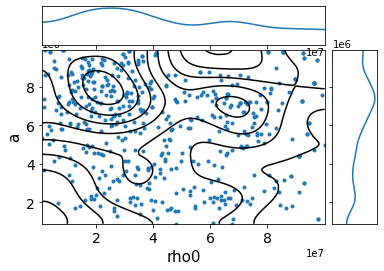

In [27]:
av.plot_pair(fit, var_names=params, kind=['kde', 'scatter'], marginals=True);

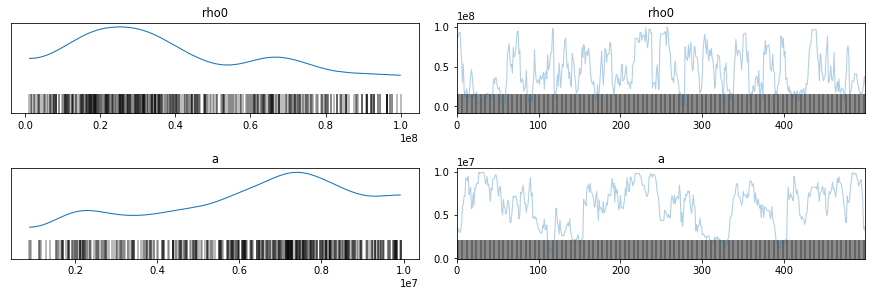

In [28]:
av.plot_trace(fit, var_names=params);

In [29]:
la = fit.extract()

In [30]:
def mass_enclosed(r, samples, full=False):
    first = 2*np.pi*samples['rho0']*samples['a']**3
    second = (r/samples['a'])**2 / (1+(r/samples['a'])**2)
    
    masses = first*second

    if full: 
        return masses
    
    return np.quantile(masses, [0.025, 0.125, 0.25, 0.5, 0.75, 0.875, 0.975]) # quantiles that we want to get

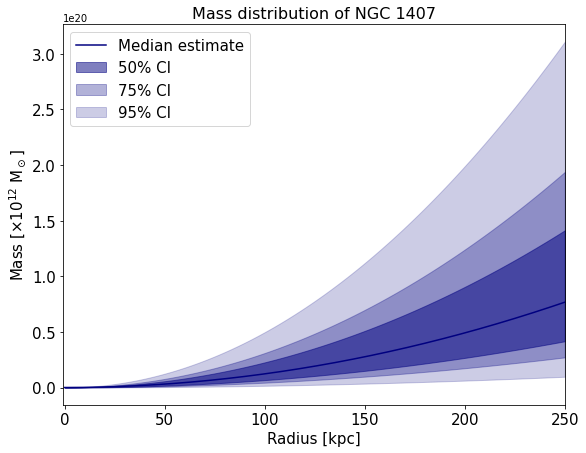

In [32]:
plt.figure(figsize=(9, 7))
radii = np.arange(251) # up to 250 kpc
masses = np.zeros((len(radii), 7))

for r in radii:
    masses[r] = mass_enclosed(r, la) # 251 x 7 array of various quantiles of masses at different radii
    
plt.plot(radii, masses[:, 3], c='navy', label='Median estimate')
plt.fill_between(radii, masses[:, 2], masses[:, 4], alpha=0.5, color='navy', label='50% CI')
plt.fill_between(radii, masses[:, 1], masses[:, 5], alpha=0.3, color='navy', label='75% CI')
plt.fill_between(radii, masses[:, 0], masses[:, 6], alpha=0.2, color='navy', label='95% CI')

plt.legend(loc='upper left', fontsize=15)
plt.title('Mass distribution of NGC 1407', fontsize=16)
plt.xlabel('Radius [kpc]', fontsize=15)
plt.ylabel(r'Mass [$\times 10^{12}$ M$_\odot$]', fontsize=15)
plt.xlim(-1, 250)
plt.xticks(size=15)
plt.yticks(size=15);